![JohnSnowLabs](https://sparknlp.org/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp/blob/master/examples/python/annotation/image/SwinForImageClassification.ipynb)

# Colab Setup

In [1]:
!wget -q http://setup.johnsnowlabs.com/colab.sh -O - | bash

Installing PySpark 3.2.3 and Spark NLP 5.4.1
setup Colab for PySpark 3.2.3 and Spark NLP 5.4.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.5/281.5 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 579.2/579.2 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 7.2 MB/s eta 0:00:00


# SwinForImageClassification Annotator

Pretrained Swin model for Image Classification, adapted from Hugging Face and curated to provide scalability and production-readiness using Spark NLP.

Swin Transformer was introduced in the paper [Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](https://arxiv.org/abs/2103.14030) by Liu et al.

In this notebok we are going to classify some images. For this we will use the Swin model published by MicroSoft.

### Downloading Images

In [2]:
!wget -q https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/images/images.zip

In [3]:
import shutil
shutil.unpack_archive("images.zip", "images", "zip")

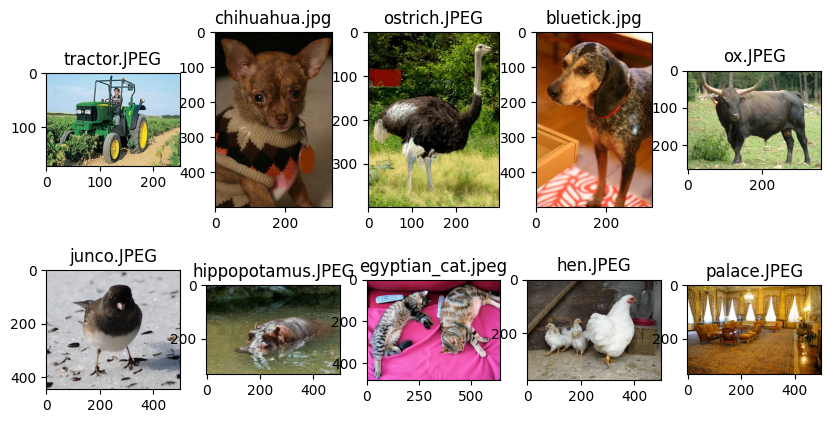

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import os

_, axes = plt.subplots(2, 5, figsize=(10,5))
axes = axes.flatten()

i = 0
for file_name in os.listdir("images/images/"):
    if file_name.lower().endswith((".png", ".jpg", ".jpeg", ".gif")):
        file_path = os.path.join("images/images/", file_name)
        ax = axes[i]
        ax.imshow(Image.open(file_path).convert("RGB"))
        ax.title.set_text(file_name)
        i += 1

### Start Spark Session

In [5]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql import SparkSession

spark = sparknlp.start()

In [6]:
data_df = spark.read.format("image").option("dropInvalid", value = True).load(path="images/images/")

### Pipeline with CLIPForZeroShotClassification

We'll be using the default [image_classifier_swin_base_patch4_window7_224](https://sparknlp.org/2023/03/28/image_classifier_swin_base_patch4_window7_224_en.html) model for the SwinForImageClassification Annotator

In [7]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

image_assembler = ImageAssembler()\
  .setInputCol("image")\
  .setOutputCol("image_assembler")

imageClassifier = SwinForImageClassification.pretrained()\
  .setInputCols("image_assembler")\
  .setOutputCol("class")

pipeline = Pipeline(stages=[
  image_assembler,
  imageClassifier,
])

image_classifier_swin_base_patch4_window7_224 download started this may take some time.
Approximate size to download 103 MB
[OK!]


In [8]:
model = pipeline.fit(data_df)
image_df = model.transform(data_df)
image_df \
    .selectExpr("reverse(split(image.origin, '/'))[0] as image_name", "class.result") \
    .show(truncate = False)

+-----------------+----------------------------------------------------------+
|image_name       |result                                                    |
+-----------------+----------------------------------------------------------+
|palace.JPEG      |[palace]                                                  |
|egyptian_cat.jpeg|[tabby, tabby cat]                                        |
|hippopotamus.JPEG|[hippopotamus, hippo, river horse, Hippopotamus amphibius]|
|hen.JPEG         |[hen]                                                     |
|ostrich.JPEG     |[ostrich, Struthio camelus]                               |
|junco.JPEG       |[junco, snowbird]                                         |
|bluetick.jpg     |[bluetick]                                                |
|chihuahua.jpg    |[Chihuahua]                                               |
|tractor.JPEG     |[tractor]                                                 |
|ox.JPEG          |[ox]                             

### Light Pipeline

To use the annotator in a light pipeline, we need to use the new method `fullAnnotateImage`, which can receive 3 kinds of input:
1. A path to a single image
2. A path to a list of images

In [9]:
light_pipeline = LightPipeline(model)
annotations_result = light_pipeline.fullAnnotateImage("images/images/hippopotamus.JPEG")
annotations_result[0].keys()

dict_keys(['image_assembler', 'class'])

To process a list of images, we just pass a list of images.

In [10]:
images = ["images/images/bluetick.jpg", "images/images/palace.JPEG", "images/images/hen.JPEG"]
annotations_result = light_pipeline.fullAnnotateImage(images)
annotations_result[0].keys()

dict_keys(['image_assembler', 'class'])

In [14]:
for result in annotations_result:
  print(result['class'][0].result)

bluetick
palace
hen
